![Changing_landscapes2021](../../media/Changing_landscapes2021_a.jpg)

# Welcome to terrainbento

If you are interested in reading about the details of terrainbento, this package is described in [Barnhart et al. (2019)](https://www.geosci-model-dev.net/12/1267/2019/).

The documentation for the package is provided [here](http://terrainbento.readthedocs.io/en/latest/).

If you are interested in the source code, you can find it [on GitHub](https://github.com/TerrainBento/terrainbento). If there is a feature that terrainbento does not have that you are interested in, if you have a clarification question, or if you find an error, please make an [Issue on GitHub](https://github.com/TerrainBento/terrainbento/issues) so we can improve the package. 

This notebook exists to provide a hyperlinked guide to the supporting examples, tests, and tutorials we have created in support of this package. 

## Introduction

terrainbento was designed to make it easy to create alternative models to be compared in Earth surface dynamics. The package has 28 model programs and a model base class that makes it possible to make additional models within the same framework. 

The simplest model, called Basic, evolves topography using stream power and linear diffusion. It has the following governing equation:

$\frac{\partial \eta}{\partial t} = - KQ^{m}S^{n} + D\nabla^2 \eta$


where $K$ and $D$ are constants, $Q$ is discharge, $S$ is local slope, and $\eta$ is the topography. Other models modify Basic by adding or changing a process component and changing the governing equation. See the [model Basic documentation](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.derived_models.model_basic.html) for additional information. 

## Let's evolve a landscape 
Let's start by simulating Landscape evolution on a simple grid using the Basic model

In [1]:
from terrainbento import Basic

# Figure properties 
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

What do we need to run the Basic model? 

*Note that Basic is a class inheriting from the ErosionModel base class. If you want to learn more on classes, objects and instances, check out [this](https://csdms.colorado.edu/wiki/Presenters-0479) webinar.*

In [2]:
# Show the documentation for the Basic model
Basic

terrainbento.derived_models.model_basic.Basic

We need a [Clock](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.clock.html) instance. The terrainbento Clock controls the timing of model runs.


In [3]:
from terrainbento import Clock

* Figure out what input arguments are needed to create a Clock instance. 
* Create a clock instance with: 
        * a model start time of 0
        * a total model time of 103 years 
        * a timestep of 100 years

In [4]:
clock = Clock(stop=10e3, step = 100)

* Make a Landlab raster grid of 15 rows, 20 columns, and 100-unit grid spacing. 
* Add a field that holds values of topographic elevation at the grid nodes. Make it zero everywhere


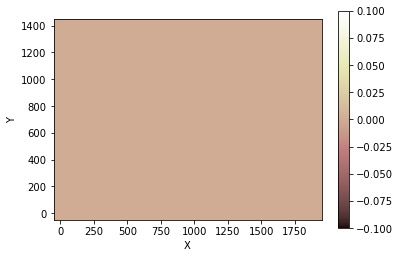

In [5]:
# Create a Landlab raster grid
from landlab import RasterModelGrid
grid = RasterModelGrid((15,20),100)
grid.add_zeros('topographic__elevation',at='node')


# Make a figure of the grid
from landlab import imshow_grid
imshow_grid(grid, 'topographic__elevation')

Create a randomized initial topography

In [6]:
from landlab.values import random

['topographic__elevation']

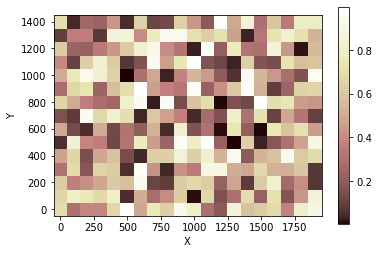

In [7]:
random(grid, "topographic__elevation")
imshow_grid(grid, 'topographic__elevation')
grid.at_node.keys()

Now that we have a clock and a grid, let's initialize 
the model using the default Basic model constructor (the `__init__` method). 

In [8]:
model = Basic(clock, grid)

Check all the fields associated to the grid

In [9]:
grid.at_node.keys()

['topographic__elevation',
 'cumulative_elevation_change',
 'initial_topographic__elevation',
 'rainfall__flux',
 'water__unit_flux_in',
 'drainage_area',
 'flow__data_structure_delta',
 'flow__upstream_node_order',
 'surface_water__discharge',
 'flow__sink_flag',
 'flow__link_to_receiver_node',
 'flow__receiver_node',
 'topographic__steepest_slope']

Terainbento is adhering to the principles of the basic model interface (BMI)
To run the model as specified, we execute the following line:

In [10]:
model.run()

## What did actually happen? 
Make a plot of the initial and final topography

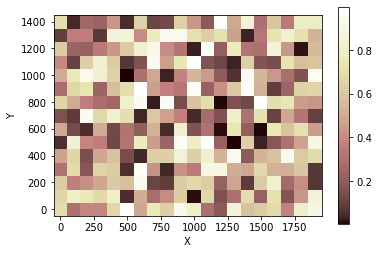

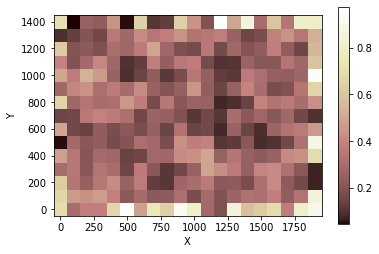

In [11]:
from matplotlib import pyplot as plt
plt.figure()
imshow_grid(model.grid, "initial_topographic__elevation")
plt.show()
plt.figure()
imshow_grid(model.grid, "topographic__elevation")
plt.show()

### Challenge
Make a new Basic model instance, run an plot the initial and calculated topography assuming: 
* a grid of 80 by 50 cells, and 100-unit grid spacing. 
* an initial random topography
* a water_erodibility coefficient of 2e-4
* a regolith_transport_parameter of 0.2
* a total model run time of 1e5 years and a step of 2000 years

In [ ]:
from landlab import RasterModelGrid
from landlab.values import random
from terrainbento import Clock
from terrainbento import Basic
grid2 = RasterModelGrid((30,20),100)
random(grid2, 'topographic__elevation')
clock = Clock(stop = 1e6, step = 2000)
model2 = Basic(clock,grid2,water_erodibility=5e-4,regolith_transport_parameter=0.01)
model2.run()
plt.figure()
imshow_grid(model2.grid, "initial_topographic__elevation")
plt.show()
plt.figure()
imshow_grid(model2.grid, "topographic__elevation")
plt.show()

Looks a little strange... why? How can we change this? 

In [13]:
# We need uplift
from terrainbento import ErosionModel
ErosionModel
#We need to adjust the boundary_handlers
# What is the default value of the boundary_handler? #None
model.boundary_handlers

{}

# Boundary Handlers

In [15]:
#How do we set a boundary handler? Boundary condition handlers are similar to landlab components. 
#They have an init method, and a run_one_step method 
from terrainbento import NotCoreNodeBaselevelHandler
#Lowering rate of the outlet node. 
grid3 = RasterModelGrid((5,5),10)
z = grid3.add_zeros('topographic__elevation',at='node')
bd_handler = NotCoreNodeBaselevelHandler(grid3,modify_core_nodes=False,lowering_rate=-0.1)

print(z.reshape(grid3.shape))
bd_handler.run_one_step(step=10)
print(z.reshape(grid3.shape))

[[ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.]]
[[-1. -1. -1. -1. -1.]
 [-1.  0.  0.  0. -1.]
 [-1.  0.  0.  0. -1.]
 [-1.  0.  0.  0. -1.]
 [-1. -1. -1. -1. -1.]]


How to provide this info to a terrainbento model run? 

From [documentation](https://terrainbento.readthedocs.io/en/latest/source/terrainbento.base_class.erosion_model.html): 
boundary_handlers (dictionary, optional) – Dictionary with `name: instance` key-value pairs. Each entry must be a valid instance of a terrainbento boundary handler.

In [ ]:
# Provide the information of the boundary handler as a dictionary
model_bd_handler ={"NotCoreNodeBaselevelHandler": bd_handler}

### Challenge 1.2 
Make a new Basic model instance, run an plot the initial and calculated topography assuming: 
* a grid of 80 by 50 cells, and 100-unit grid spacing. 
* an initial random topography
* a water_erodibility coefficient of 2e-4
* a regolith_transport_parameter of 0.2
* a total model run time of 1e5 years and a step of 2000 years
* an uplift rate of 0.002 m/year (sea level stays fixed at ca. 0m) 

In [ ]:
from landlab import RasterModelGrid
from landlab.values import random
from terrainbento import Clock
from terrainbento import Basic
grid2 = RasterModelGrid((80,50),100)
random(grid2, 'topographic__elevation')
clock = Clock(stop = 1e5, step = 2000)
# Provide the information of the boundary handler as a dictionary
bd_handler = NotCoreNodeBaselevelHandler(grid2,modify_core_nodes=True,lowering_rate=-0.002)
bd_handler ={"NotCoreNodeBaselevelHandler": bd_handler}
model2 = Basic(clock,grid2,water_erodibility=2e-4,regolith_transport_parameter=0.2,
               boundary_handlers=bd_handler)
model2.run()
plt.figure()
imshow_grid(model2.grid, "initial_topographic__elevation")
plt.show()
plt.figure()
imshow_grid(model2.grid, "topographic__elevation")
plt.show()

## Example usage

There are three additional introductory tutorials.

1) [Introduction terrainbento](example_usage/Introduction_to_terrainbento.ipynb)
    
2) [Introduction to boundary conditions in terrainbento](example_usage/introduction_to_boundary_conditions.ipynb)
    
3) [Introduction to output writers in terrainbento](example_usage/introduction_to_output_writers.ipynb). 
    

## Example Coupled Models

This section provides links to five notebooks that show the usage of five example models provided in terrainbento. In each of these notebooks we provide the governing equation(s) for the model, initialize and run the model, make a slope-area plot, save a NetCDF of the final topography, and plot a image of the final topography. 

1) [Basic](coupled_process_elements/model_basic_steady_solution.ipynb) the simplest landscape evolution model in the terrainbento package.

2) [BasicVm](coupled_process_elements/model_basic_var_m_steady_solution.ipynb) which permits the drainage area exponent to change

3) [BasicCh](coupled_process_elements/model_basicCh_steady_solution.ipynb) which uses a non-linear hillslope erosion and transport law

4) [BasicVs](coupled_process_elements/model_basicVs_steady_solution.ipynb) which uses variable source area hydrology

5) [BasisRt](coupled_process_elements/model_basicRt_steady_solution.ipynb) which allows for two lithologies with different K values

6) [RealDEM](coupled_process_elements/model_basic_realDEM.ipynb) Run the basic terrainbento model with a real DEM as initial condition. 

## Terrainnbento challenge
- [Make your own gif](coupled_process_elements/Challenge.ipynb)